<a href="https://colab.research.google.com/github/hungviet0304/DS_Final_project/blob/master/DS_collect_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Crawling data**
 - Data source: https://www.imdb.com/
 - In 8 categories: action, comedy, Adventure,Animation, Crime, Romance, Documentary, Biography
 - Colecting 10000 samples each category

In [ ]:
import lxml
import re
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from requests import get
import urllib.robotparser #check robot.txt from url file

In [ ]:
#check robots.txt from urls
def check_robot(url):
    base_url = url.split("//")[-1].split("/")[0].split('?')[0] #get host name from URL
    url_robot = "https://"+base_url+"/robots.txt"
    rp = urllib.robotparser.RobotFileParser()
    rp.set_url(url_robot)
    try:
        conn = urllib.request.urlopen(url_robot)
    except urllib.error.HTTPError as e:
        # Return code error (e.g. 404, 501, ...)
        # ...
        #print('HTTPError: {}'.format(e.code)) ##page have not robots.txt file
        return True
    except urllib.error.URLError as e:
        # Not an HTTP-specific error (e.g. connection refused)
        # ...
        #print('URLError: {}'.format(e.reason))
        return True
    else:
        # 200
        # ...
        #print('good')
        #check robot when able to access page
        rp.read()
        return rp.can_fetch('*', url) #True is ok to crawl

In [ ]:
def crawling(url_next_page, genre):

  position = 1
  url = url_next_page.format(genre, position).lower()
  print(url)
  if (check_robot(url) == False): 
        return None #cant crawl this url
  page = get(url)
  s = BeautifulSoup(page.content,'lxml')

  #page title
  page_title = s.find("h1", class_ = "header").text.replace("\n","")
  body = s.find(id = 'main')
  content = body.find_all("div", class_ = "lister-item mode-advanced")
  total_results = 0
  # movie_title = [] #
  # movie_date = []
  # movie_runtime = []#
  # movie_genre = []#
  # movie_rating = []
  # movie_score = []
  # movie_description = []
  # movie_directors = []
  # movie_stars = []
  # movie_votes = []
  # movie_gros = []
  df = pd.DataFrame(columns = ["title", "runtime","des","date","rating","genre"])
  total_results = body.find("div",class_ = 'desc')
  total_results = total_results.find('span').text.replace(",","")
  total_results = int(re.findall(r'\d+',total_results)[-1])
  print("total results: {}".format(total_results))
  total_results = int(total_results)
  num_of_pages = total_results // 50 + 1 if total_results / 50 > total_results // 50 else total_results //50
  print(num_of_pages)
  num_of_pages /= 2
  count = 0
  while True:

    for movie in content:
      tmp = movie.find("h3",class_ = "lister-item-header")
      movie_title=tmp.find("a").text

      try:
        movie_runtime = movie.find('span',class_ = 'runtime').text[:-4] # only number
      except:
        movie_runtime = 0
        # print("error at runtime: " + movie_title)

      try:
        movie_genre=movie.find('span',class_= 'genre').text.replace("\n","")
      except:
        movie_genre = ""
        # print("error at genre" + movie_title)
      try:
        movie_description = movie.find_all('p',class_ = "text-muted")[-1].text.replace("\n","")
      except:
        # print("error at description: " + movie_title)
        movie_description = ""
      try:
        movie_date = tmp.find_all("span")[-1].text
        movie_date = int(re.findall(r'\d+',movie_date)[-1])
      except:
        movie_date = 0
        # print("error at date:" + movie_title)
      try:
        movie_rating = movie.find("strong").text
      except:
        movie_rating = '0'
        # print("error at rating: " + movie_title)

      df.loc[len(df)] = [movie_title, movie_runtime, movie_description,movie_date, movie_rating, movie_genre]
      if df.shape[0] >= 10000:
        # print()
        return df[:10000]
    position += 50
    url = url_next_page.format(genre,position).lower()
    if (check_robot(url) == False): 
      return None #cant crawl this url
    page = get(url)
    s = BeautifulSoup(page.content,'lxml')

    #page title
    page_title = s.find("h1", class_ = "header").text.replace("\n","")
    body = s.find(id = 'main')
    content = body.find_all("div", class_ = "lister-item mode-advanced")
    count += 1
    # print(str(count) + " / " + str(num_of_pages))
    if count == num_of_pages:
      break
  return df

In [ ]:
def crawling_genre(url, genre):
  for g in genre:
    print("crawling " + g)
    df_tmp = crawling(url,g)
    print("crawed {}".format(df_tmp.shape[0]))
    df_tmp.to_csv(g+".csv",index = False)


In [ ]:
url = "https://www.imdb.com/search/title/?release_date=2010-10-10,2018-10-10&genres={}&languages=en&start={}&ref_=adv_nxt"
df = crawling_genre(url,['Action','Comedy','Adventure','Animation','Crime','Romance','Documentary','Biography'])

Data Visualization

In [ ]:
genres = ['Action','Comedy','Adventure','Animation','Crime','Romance','Documentary','Biography']

In [ ]:
import pandas as pd

In [91]:
data_path = "./data/final_data.csv"
df = pd.read_csv(data_path)

In [92]:
df.columns

Index(['title', 'runtime', 'des', 'date', 'rating', 'genre', 'genres'], dtype='object')

In [ ]:
# drop duplicate rows in data frame
droped_df = df.drop_duplicates(keep = "first")

In [95]:
def remove_unneccessary_genre(df):
    gen_list = df.genre.values.tolist()
    gens = []
    for g in gen_list:
        tmp = g.strip().split(", ")
        gen_ = [x for x in tmp if x in genres]
        gens.append(gen_)
    new_gens = [",".join(x for x in gen) for gen in gens]     
    df_new_gens = pd.DataFrame(new_gens)
    df['genres'] = new_gens
    df.drop(columns = ['genre'])
    return df

In [96]:
df = remove_unneccessary_genre(droped_df)

In [88]:
# only run this cell if you want to save current data frame
df.to_csv(data_path + "final_data.csv", index = False)

In [97]:
#extract genres for statistic
gens_list = df.genres.values.tolist()
gens = []
for g in gen_list:
    tmp = g.strip().split(", ")
    gen_ = [x for x in tmp if x in genres]
    gens.append(gen_)
new_list_gen = []
for g in gens:
    new_list_gen += g

In [98]:
from nltk import FreqDist
from matplotlib import pyplot as plt
import seaborn as sns

In [99]:
freq = FreqDist(new_list_gen)
frq = pd.DataFrame({"Genre": list(freq.keys()),
                   "Freq": list(freq.values())})

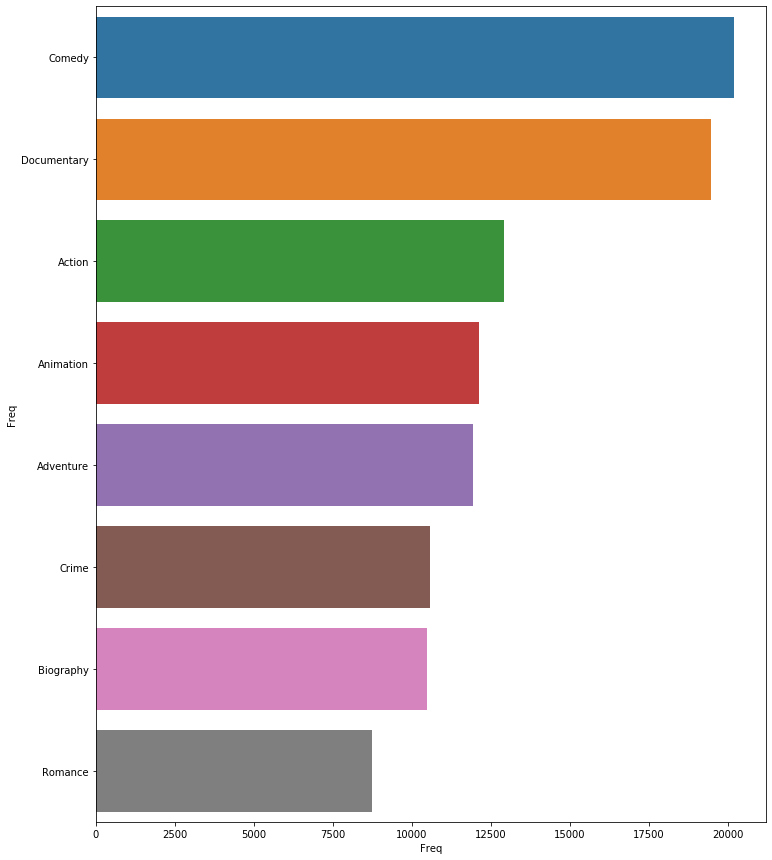

In [100]:
g = frq.nlargest(columns="Freq", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Freq", y = "Genre") 
ax.set(ylabel = 'Freq') 
plt.show()